# Prueba de Desempeño en Algoritmo de multiplicación de matrices cuadradas
Versión secuencial VS Versión Concurrente

## Selección de Método para medir el tiempo de CPU de Usuario
Se evaluarán primero algunas funciones para medir el tiempo y saber cuál es más precisa para determinar el tiempo de *CPU de usuario*

### Prueba 1 algoritmo secuencial usando time.perf_counter()

In [1]:
import random, time
from resource import getrusage as resource_usage, RUSAGE_SELF
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
acum = 0
tic = time.perf_counter()
for i in range(200000):
    acum+= i
toc = time.perf_counter()
print(f"Sum in {toc - tic:0.12f} seconds")


Sum in 0.027164500032 seconds


### Prueba 2 algoritmo secuencial usando resource_usage
 'real': end_time - start_time, \
 'sys': end_resources.ru_stime - start_resources.ru_stime, 
 ##### 'user': end_resources.ru_utime - start_resources.ru_utime

In [3]:
acum = 0
start_resources = resource_usage(RUSAGE_SELF)
for i in range(200000):
    acum+= i
end_resources = resource_usage(RUSAGE_SELF)
timeCPU = end_resources.ru_utime - start_resources.ru_utime
print("Sum in {0:.10f} seconds".format(timeCPU))

#print('Result:')
#for r in result:
  # print(r)

Sum in 0.0312500000 seconds


Nota: Para este laboratorio se elegirá resource_usage, ya que aisla de una mejor forma el tiempo de CPU de usuario





# Algoritmo para Multiplicación de Matrices

## Algoritmo secuencial

Definición de las Funciones que se usarán

In [36]:
def reset_to_0(the_array):
    for i, e in enumerate(the_array):
        if isinstance(e, list):
            reset_to_0(e)
        else:
            the_array[i] = 0

#Create matrix
def createMatrix(n):
    a =[]
    b =[]
    r= []
    matrix1 =[]
    matrix2 =[]
    result = []

    for i in range(n):
        for i in range(n):
            number = random.randrange(10)
            number2 = random.randrange(10)
            a.append(number)
            b.append(number2)
            r.append(0)
        matrix1.append(a)
        matrix2.append(b)
        result.append(r)
        a = []
        b = []
        r = []
    return matrix1, matrix2, result

#Prueba de verificacion. No se recomienda su ejecucion para n>10
# print('Matrix 1')
# for m in matrix1:
#     print(m)

# print('Matrix 2')
# for m in matrix2:
#     print(m)

#Multiply Matrix
def multiplyMatrix(matrix1, matrix2, result):
    start_resources = resource_usage(RUSAGE_SELF)
    #iterate through rows of matrix1
    for i in range(n):
       # iterate through columns of matrix2
       for j in range(n):
           # iterate through rows of matrix2
           for k in range(n):
               result[i][j] += matrix1[i][k] * matrix2[k][j]
    end_resources = resource_usage(RUSAGE_SELF)
    timeCPU = end_resources.ru_utime - start_resources.ru_utime
    # print("Matrix multiplication in {0:.10f} seconds".format(timeCPU))
    return timeCPU

# Average Function
def average(list): 
    return sum(list) / len(list)

def averageTime(list1, list2, list3, list4,list5,list6,list7,list8):
    return [average(list1), average(list2), average(list3),average(list4),average(list5),average(list6),average(list7),average(list8) ]

def makeChart(xAxis,yAxis):
    plt.bar(xAxis,yAxis, width=3)
    plt.plot(xAxis, yAxis, color='red')
    plt.title('Matrix Size Vs Average CPU User time')
    plt.xlabel('Matrix Size (N)')
    plt.ylabel('Time (in s)')
    plt.grid(alpha=.7)
    plt.show()

## Algoritmo Concurrente

Para poder implementarlo de manera concurrente vamos a usar hilos, con el fin de que la multiplicación por columnas se pueda realizar de manera simultanea. Es decir, un hilo se encarga de realizar la multiplicación en un rango específico de columnas mientras el otro lo hace con un rango distinto.
Para la librería de hilos usamos threading. Además, debemos definir una constante que contenga el número de hilos que vamos a utilizar


In [28]:
from threading import Thread
NUM_OF_THREADS = 4
serialTime = []
concTime = []

Debemos cambiar la manera en la que se realiza la multiplicación ya que no se recorren todas las filas, si no que se hacen en un rango especifico para cada hilo.

In [6]:
def multiplyParallelMatrix(start, end):
    # iterate through rows of matrix1 int that were assigned o that thread
    for i in range(start, end):
        # iterate through columns of matrix2
        for j in range(n):
            # iterate through rows of matrix2
            for k in range(n):
                result[i][j] += matrix1[i][k] * matrix2[k][j]

Después creamos una función que hará el manejo de los hilos. Hará el cálculo de cuántas filas serán asignadas por hilo dividiendo el número de filas con el número de hilos. En caso de que la división no sea exacta y queden filas saltantes la variable offset nos indicará cuántas son para que el último hilo creado se encargue de ellas.
Adicionalmente dentro de la misma función se inician los hilos y se da la instrucción de espera para la sincronización de los mismos.

In [54]:
def threadFunction():
    arrayThreads=[]
    global n
    # Number of threads: 2,3 & 4
    for NUM_OF_THREADS in range(2,5):

        thread_handle = []
        row_range = int(n/NUM_OF_THREADS)
        # Calculating the offset
        offset = n % NUM_OF_THREADS
        # Start time counting

        start_resources = resource_usage(RUSAGE_SELF)
        for j in range(0, NUM_OF_THREADS):

            # If the number if rows can be divided by the number of threads
            if offset == 0:
                t = Thread(target=multiplyParallelMatrix, args=(
                    int((row_range) * j), int((row_range) * (j+1))))
            else:
                # if there are remaining rows
                if j == NUM_OF_THREADS - 1:
                    t = Thread(target=multiplyParallelMatrix, args=(
                        int((row_range) * j), int(((row_range) * (j+1))+offset)))
                else:
                    t = Thread(target=multiplyParallelMatrix, args=(
                        int((row_range) * j), int((row_range) * (j+1))))

            thread_handle.append(t)
            t.start()

        for j in range(0, NUM_OF_THREADS):
            thread_handle[j].join()

        # End time counting

        end_resources = resource_usage(RUSAGE_SELF)
        timeCPU = end_resources.ru_utime - start_resources.ru_utime
        arrayThreads.append(timeCPU)

    return arrayThreads


Dentro de esta función también se hará el conteo del tiempo de CPU de usuario teniendo en cuenta la barrera de sincronización 

In [55]:
# Main function:
if __name__ == "__main__":
    # Values for n
    matrixSizeN = [100,120,140,160,180,200,220,240]
    #Serial arrays
    size100 = []
    size120 = []
    size140 = []
    size160 = []
    size180 = []
    size200 = []
    size220 = []
    size240 = []

    #concurrent arrays
    size100With2Threads = []
    size100With3Threads = []
    size100With4Threads = []

    size120With2Threads = []
    size120With3Threads = []
    size120With4Threads = []
    
    size140With2Threads = []
    size140With3Threads = []
    size140With4Threads = []
    
    size160With2Threads = []
    size160With3Threads = []
    size160With4Threads = []
    
    size180With2Threads = []
    size180With3Threads = []
    size180With4Threads = []
    
    size200With2Threads = []
    size200With3Threads = []
    size200With4Threads = []
    
    size220With2Threads = []
    size220With3Threads = []
    size220With4Threads = []
    
    size240With2Threads = []
    size240With3Threads = []
    size240With4Threads = []

    for i in range (10):
        for n in matrixSizeN:
            #Execution for serial matrixMult
            matrix1, matrix2, result = createMatrix(n)
            time = multiplyMatrix(matrix1, matrix2, result)

            #Execution for concurrent matrixMult
            reset_to_0(result)
            concTime = threadFunction()

            # print('Multi matrix size: {} . Loop: {} .Time: {}'.format(n,i, concTime))

            if n== 100:
                size100.append(time)
                size100With2Threads.append(concTime[0])
                size100With3Threads.append(concTime[1])
                size100With4Threads.append(concTime[2])
            elif n == 120:
                size120.append(time)
                size120With2Threads.append(concTime[0])
                size120With3Threads.append(concTime[1])
                size120With4Threads.append(concTime[2])
            elif n == 140:
                size140.append(time)
                size140With2Threads.append(concTime[0])
                size140With3Threads.append(concTime[1])
                size140With4Threads.append(concTime[2])
            elif n == 160:
                size160.append(time)
                size160With2Threads.append(concTime[0])
                size160With3Threads.append(concTime[1])
                size160With4Threads.append(concTime[2])
            elif n == 180:
                size180.append(time)
                size180With2Threads.append(concTime[0])
                size180With3Threads.append(concTime[1])
                size180With4Threads.append(concTime[2])
            elif n == 200:
                size200.append(time)
                size200With2Threads.append(concTime[0])
                size200With3Threads.append(concTime[1])
                size200With4Threads.append(concTime[2])
            elif n == 220:
                size220.append(time)
                size220With2Threads.append(concTime[0])
                size220With3Threads.append(concTime[1])
                size220With4Threads.append(concTime[2])
            elif n == 240:
                size240.append(time)
                size240With2Threads.append(concTime[0])
                size240With3Threads.append(concTime[1])
                size240With4Threads.append(concTime[2])
            else: 
                print('Error')

     # xAxis = averageTime    yAxis = matrixSize
    averageSerialTimeList = averageTime(size100, size120, size140, size160, size180,size200,size220,size240)

    averageWith2Threads = averageTime(size100With2Threads, size120With2Threads, size140With2Threads, size160With2Threads,size180With2Threads,size200With2Threads,size220With2Threads,size240With2Threads)
    
    averageWith3Threads = averageTime(size100With3Threads, size120With3Threads, size140With3Threads, size160With3Threads,size180With3Threads,size200With3Threads,size220With3Threads,size240With3Threads)
    
    averageWith4Threads = averageTime(size100With4Threads, size120With4Threads, size140With4Threads, size160With4Threads,size180With4Threads,size200With4Threads,size220With4Threads,size240With4Threads)
  

A continuación se analizarán los resultados de la multiplicación de matrices, para el modelo que usa las funciones secuenciales y el modelo que usa las funciones concurrentes:

In [56]:
concTime = averageConcTimeList
#Serial Version
print('Test n sizes: ')
print(matrixSizeN)
print('Serial Average CPU time:')
print(averageSerialTimeList)
#Concurrent Version
print('Concurrent Average CPU time with 2 Threads:')
print(averageWith2Threads)

print('Concurrent Average CPU time with 3 Threads:')
print(averageWith3Threads)

print('Concurrent Average CPU time with 4 Threads:')
print(averageWith4Threads)



Test n sizes: 
[100, 120, 140, 160, 180, 200, 220, 240]
Serial Average CPU time:
[0.2609375, 0.421875, 0.6453125, 1.0671875, 1.45625, 2.0015625, 2.7109375, 3.578125]
Concurrent Average CPU time with 2 Threads:
[0.359375, 0.5578125, 0.9015625, 1.3328125, 1.9515625, 2.728125, 3.5609375, 4.690625]
Concurrent Average CPU time with 3 Threads:
[0.3515625, 0.571875, 0.9359375, 1.33125, 1.990625, 2.728125, 3.6484375, 4.8125]
Concurrent Average CPU time with 4 Threads:
[0.328125, 0.578125, 0.9640625, 1.35, 1.934375, 2.815625, 3.5578125, 4.796875]


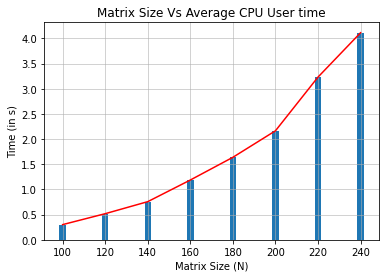

In [59]:
# makeChart(xAxis,yAxis) Chart for Serial Algorithm
makeChart(matrixSizeN, serialTime)

## Gráfico con el comparativo de ambos tiempos de CPU de usuario
En azul: tiempo usando algoritmo secuencial
 <br>
 <br>
En verde: tiempo usando algoritmo concurrente con 2 hilos  <br>
En naranja: tiempo usando algoritmo concurrente con 3 hilos  <br>
En rojo: tiempo usando algoritmo concurrente con 4 hilos

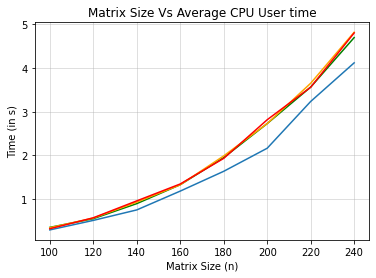

In [61]:
#plt.bar(matrixSizeN,averageTimeList)
plt.plot(matrixSizeN, serialTime)
plt.plot(matrixSizeN, averageWith2Threads, color='green')
plt.plot(matrixSizeN, averageWith3Threads, color='orange')
plt.plot(matrixSizeN, averageWith4Threads, color='red')

plt.title('Matrix Size Vs Average CPU User time')
plt.xlabel('Matrix Size (n)')
plt.ylabel('Time (in s)')
plt.grid(alpha=.5)
plt.show()

## Speedup

El Speedup observado del código que ha sido transformado, está definido como el tiempoEjecucionSecuencial / tiempoEjecucionConcurrente
 <br>
<br>
En verde: tiempo usando algoritmo concurrente con 2 hilos  <br>
En naranja: tiempo usando algoritmo concurrente con 3 hilos  <br> 
En rojo: tiempo usando algoritmo concurrente con 4 hilos


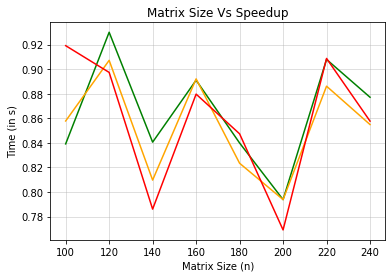

In [62]:
from numpy import divide
# plt.bar(matrixSizeN,speedUp)
plt.plot(matrixSizeN, divide(serialTime, averageWith2Threads), color='green')
plt.plot(matrixSizeN, divide(serialTime, averageWith3Threads), color='orange')
plt.plot(matrixSizeN, divide(serialTime, averageWith4Threads), color='red')
plt.title('Matrix Size Vs Speedup')
plt.xlabel('Matrix Size (n)')
plt.ylabel('Time (in s)')
plt.grid(alpha=.5)
plt.show()


# Medición de tiempo de ejecución del programa completo

## Secuencial
Tiempo de Ejecución Algoritmo Secuencial


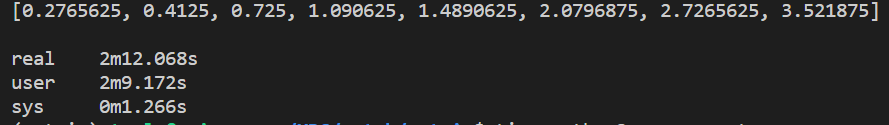

In [63]:
from IPython import display 
display.Image("serialTime.PNG")


## Concurrente
Tiempo de Ejecución Algoritmo Concurrente


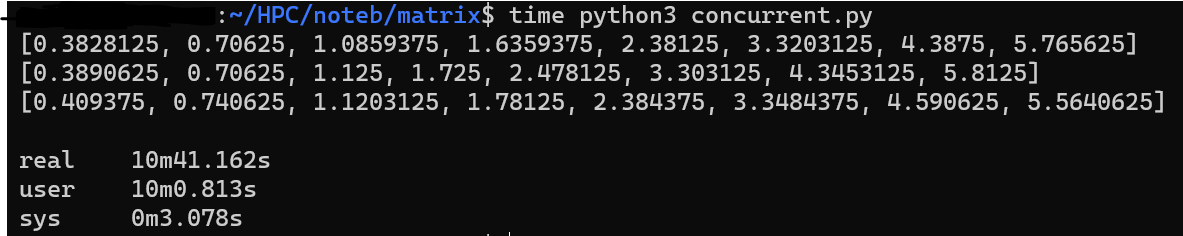

In [66]:
display.Image("concurrent.PNG")